Выбор локации для скважины
======

*Входные данные:*  
Представлены пробы нефти в трёх регионах. Известны характеристики для каждой скважины в регионе. 
  
*Задача:*  
Построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.  
  
*Описание данных:*  
   
`id` — уникальный идентификатор скважины;  
`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product` — объём запасов в скважине (тыс. баррелей).  
  
*Условия:*  
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
- Бюджет на разработку скважин в регионе — 10 млрд рублей.  
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  


## Открытие файлов, изучение общей информации и подготовка данных

Импорт библиотек

In [1]:
# ! pip install pandas-profiling

In [2]:
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Загрузка данных из файлов в датафреймы

In [3]:
try:
    data_0 = (
        pd.read_csv('/Users/darakasina/Desktop/DS/Проекты/project_oil_well_location/geo_data_0.csv', sep=',')
    )
    data_1 = (
        pd.read_csv('/Users/darakasina/Desktop/DS/Проекты/project_oil_well_location/geo_data_1.csv', sep=',')
    )
    data_2 = (
        pd.read_csv('/Users/darakasina/Desktop/DS/Проекты/project_oil_well_location/geo_data_2.csv', sep=',')
    )
    
except:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')

### Изучение общей информации о полученных датафреймах

In [4]:
data_0.info(), print(), data_1.info(), print(), data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

(None, None, None, None, None)

Т.к. мы имеем три абсолютно одинаковых датафрейма: для удобства анализы и работы объединим их, добавив категориальный столбец `region` = номер датафрейма (номер региона)

In [5]:
data_0['region'] = 0
data_1['region'] = 1
data_2['region'] = 2

display(data_0.head(3))
display(data_1.head(3))
display(data_2.head(3))

id        f0        f1        f2     product  region
0  txEyH  0.705745 -0.497823  1.221170  105.280062       0
1  2acmU  1.334711 -0.340164  4.365080   73.037750       0
2  409Wp  1.022732  0.151990  1.419926   85.265647       0

id         f0        f1        f2     product  region
0  kBEdx -15.001348 -8.276000 -0.005876    3.179103       1
1  62mP7  14.272088 -3.475083  0.999183   26.953261       1
2  vyE1P   6.263187 -5.948386  5.001160  134.766305       1

id        f0        f1        f2    product  region
0  fwXo0 -1.146987  0.963328 -0.828965  27.758673       2
1  WJtFt  0.262778  0.269839 -2.530187  56.069697       2
2  ovLUW  0.194587  0.289035 -5.586433  62.871910       2

In [6]:
data = pd.concat([data_0, data_1, data_2], axis=0).reset_index(drop=True)
data.tail()

id        f0        f1        f2     product  region
299995  4GxBu -1.777037  1.125220  6.263374  172.327046       2
299996  YKFjq -1.261523 -0.894828  2.524545  138.748846       2
299997  tKPY3 -1.199934 -2.957637  5.219411  157.080080       2
299998  nmxp2 -2.419896  2.417221 -5.548444   51.795253       2
299999  V9kWn -2.551421 -2.025625  6.090891  102.775767       2

Проверим количество уникальных значений в столбце `id` - если все `id` точек разные, то они нам не понадобятся и мы сможем их удалить (делать предсказания по абсолютно разным признакам мы не сможем):

In [7]:
data.id.value_counts().head()

uSye4    2
KUPhW    2
5ssQt    2
D8TNs    2
A5aEY    2
Name: id, dtype: int64

Некоторые id повторяются по 2 раза. Проверим датасет на явные дубликаты:

In [8]:
data = data.drop_duplicates().reset_index(drop=True) 
data.id.value_counts().head()

uSye4    2
KUPhW    2
5ssQt    2
D8TNs    2
A5aEY    2
Name: id, dtype: int64

Посмотрим на строки с повторяющимися id:

In [9]:
with pd.option_context('display.max_rows', None):
    print(data[data.duplicated(subset='id', keep=False)].sort_values(by='id'))

           id         f0         f1         f2     product  region
227380  2tyMi  -1.789602  -1.359044  -4.840745  145.901447       2
45429   2tyMi   0.576679  -0.411140  -3.725859   69.292672       0
105849  5ltQ6  -3.435401 -12.296043   1.999796   57.085625       1
184461  5ltQ6  18.213839   2.191999   3.993869  107.813044       1
272896  5ssQt  -0.651825   0.782415   2.690636  120.108761       2
16753   5ssQt  -1.005117   0.268726  -0.407822   53.206029       0
66136   74z30   1.084962  -0.312358   6.990771  127.643327       0
64022   74z30   0.741456   0.459229   5.153109  140.771492       0
3389    A5aEY  -0.039949   0.156872   0.209861   89.249364       0
51970   A5aEY  -0.180335   0.935548  -2.094773   33.020205       0
69163   AGS9W  -0.933795   0.116194  -3.655896   19.230453       0
42529   AGS9W   1.454747  -0.479651   0.683380  126.370504       0
14777   CXJ2r   1.799663   0.152615   2.308270  124.783815       0
123086  CXJ2r   4.595329  -1.967882   4.000767  107.813044    

Мы наблюдаем два случая совпадений `id`:  
1) `id` совпадают в одном и том же регионе, но имеют разные признаки (три признака точек и объем запасов в скважине). Т.к. идентификаторы скважин уникальны, то в случае повторения одного и того же `id`в рамках одного региона мы можем сделать вывод, что возможно в датасет попали данные за разные периоды. Какой период (какую строку) считать актуальным и значимым для дальнейших предсказаний мы без дополнительного уточнения данных у заказчика не можем определить, поэтому удалять ничего в таких случаях не будем.   
2) `id` совпадают в разных регионах и при этом опять же имеют разные признаки (ни в одном из случаев признаки не совпадают), что также странно, потому что вряд ли существуют две идентичных по характеристикам скважины в разных регионах (мы видимо это хотя бы по признакам f0, f1, f2, product). Скорее всего это ошибка при генерации синтических данных или, например, ошибка при шифровании реальных данных (и один и тот же id 'проскочил' в разные датасеты). Или может быть данные за разные периоды по одной скважине ошибочно попали в данные по разным регионам (а не по разным периодам). Без дополнительной информации от заказчика самостоятельно решить, какая из строк правильнее/важнее мы не можем, поэтому строки трогать не будем. 
3) Интересно, что в строке под индексом 138405 (id=uMqiK) объем запасов в скважине - 0 тыс. барр. Либо это выброс (т.к. точность указывается до шестого знака после запятой), либо, если теория о данных за разные периоды времени верна, запасы нефти в данной скважине полностью исчерпаны).  
4) Также неизвестно, по каким именно регионам представлены данные. Возможно, что географически скважина сначала принадлежала одному региону, затем другому, и срез данных брался в разные периоды времени.  

Ни одно из предположений мы не можем подтвердить/опровергнуть без дополнительной информации.
  
Столбец `id` удалим из датасета, т.к. полезной информации для анализа и предсказаний он не несет. Предсказывать сам `id` мы также не будем.

In [10]:
data = data.drop(columns = 'id')
data.head()

f0        f1        f2     product  region
0  0.705745 -0.497823  1.221170  105.280062       0
1  1.334711 -0.340164  4.365080   73.037750       0
2  1.022732  0.151990  1.419926   85.265647       0
3 -0.032172  0.139033  2.978566  168.620776       0
4  1.988431  0.155413  4.751769  154.036647       0

Посмотрим информацию о числовых колонках:

In [11]:
data[data.region == 0].describe()

f0             f1             f2        product    region
count  100000.000000  100000.000000  100000.000000  100000.000000  100000.0
mean        0.500419       0.250143       2.502647      92.500000       0.0
std         0.871832       0.504433       3.248248      44.288691       0.0
min        -1.408605      -0.848218     -12.088328       0.000000       0.0
25%        -0.072580      -0.200881       0.287748      56.497507       0.0
50%         0.502360       0.250252       2.515969      91.849972       0.0
75%         1.073581       0.700646       4.715088     128.564089       0.0
max         2.362331       1.343769      16.003790     185.364347       0.0

In [12]:
data[data.region == 1].describe()

f0             f1             f2        product    region
count  100000.000000  100000.000000  100000.000000  100000.000000  100000.0
mean        1.141296      -4.796579       2.494541      68.825000       1.0
std         8.965932       5.119872       1.703572      45.944423       0.0
min       -31.609576     -26.358598      -0.018144       0.000000       1.0
25%        -6.298551      -8.267985       1.000021      26.953261       1.0
50%         1.153055      -4.813172       2.011479      57.085625       1.0
75%         8.621015      -1.332816       3.999904     107.813044       1.0
max        29.421755      18.734063       5.019721     137.945408       1.0

In [13]:
data[data.region == 2].describe()

f0             f1             f2        product    region
count  100000.000000  100000.000000  100000.000000  100000.000000  100000.0
mean        0.002023      -0.002081       2.495128      95.000000       2.0
std         1.732045       1.730417       3.473445      44.749921       0.0
min        -8.760004      -7.084020     -11.970335       0.000000       2.0
25%        -1.162288      -1.174820       0.130359      59.450441       2.0
50%         0.009424      -0.009482       2.484236      94.925613       2.0
75%         1.158535       1.163678       4.858794     130.595027       2.0
max         7.238262       7.844801      16.739402     190.029838       2.0

Посмотрим на распределение запасов нефти по трем регионам:

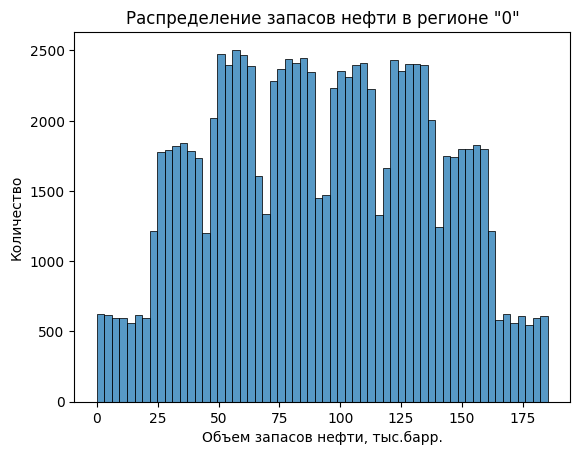

In [14]:
data_plot = sns.histplot(data[data.region==0]['product'])
data_plot.set_title('Распределение запасов нефти в регионе "0"', size=12)
data_plot.set_xlabel('Объем запасов нефти, тыс.барр.')
data_plot.set_ylabel('Количество')
fig = data_plot.get_figure();

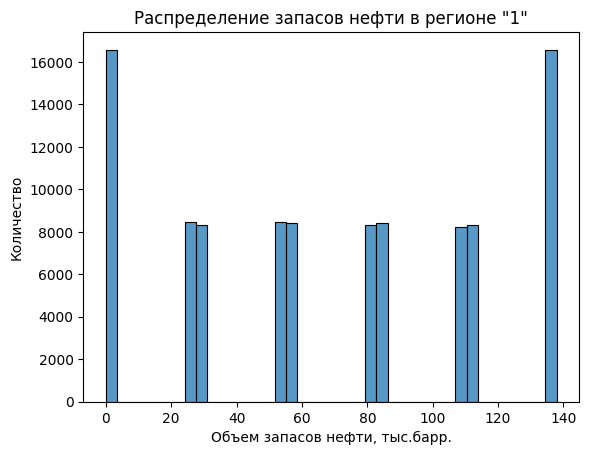

In [15]:
data_plot = sns.histplot(data[data.region==1]['product'])
data_plot.set_title('Распределение запасов нефти в регионе "1"', size=12)
data_plot.set_xlabel('Объем запасов нефти, тыс.барр.')
data_plot.set_ylabel('Количество')
fig = data_plot.get_figure();

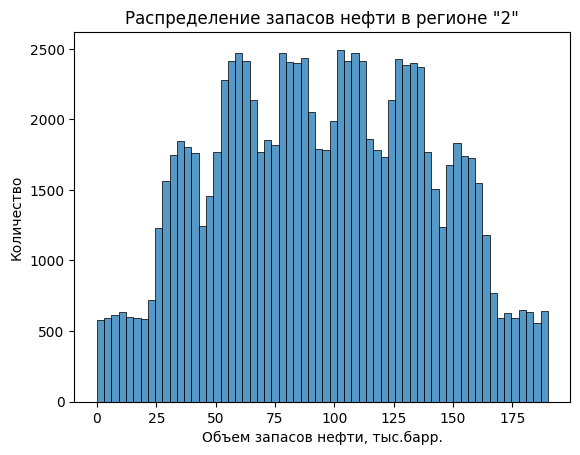

In [16]:
data_plot = sns.histplot(data[data.region==2]['product'])
data_plot.set_title('Распределение запасов нефти в регионе "2"', size=12)
data_plot.set_xlabel('Объем запасов нефти, тыс.барр.')
data_plot.set_ylabel('Количество')
fig = data_plot.get_figure();

Распределение запасов нефти в 0-м и 2-м регионах практически идентичны. "Околонормальное распределение". 1-ый регион имеет странное, не характерное распределение. Возможно, это связано с искуственностью данных.
Посмотрим на другие статистики каждого региона при помощи pandas_profile:

In [17]:
profile = ProfileReport(data[data.region==0], progress_bar=False)
profile

In [18]:
profile = ProfileReport(data[data.region==1], progress_bar=False)
profile

In [19]:
profile = ProfileReport(data[data.region==2], progress_bar=False)
profile

`f0` сильно коррелирует с region  
`f0` имеет нормальное распределение по трем регионам суммарно.  min=-31.61, max=29.42, mean=0.54  
`f1` имеет немного смещенную гистограмму влево (пик смещен вправо). min=-26.36, max=18.73, mean=-1.52  
`f2` имеет нормальное распределение по трем регионам суммарно с большими выбросами.  min=-12.09, max=16.74, mean=2.50  
`f2` сильно коррелирует с product  
`product` имеет 8237 нулей (2,7% от общего датасета) - исчерпанные скважины или выбросы? min=85.44, max=190.03, mean=85.44  

Нулевой объем запасов в скважинах не будем убирать из датасета, т.к. если это реальные данные, модель не сможет научиться предсказывать уже исчерпанные скважины нефти. Отдельные выбросы по продукту и признаку f2 также не будем удалять/редактировать, т.к. мы не знаем, каким образом получены такие данные и что именно они значат. Действительно ли это выбросы.

Ради интереса посмотрим на распределение признаков точек по регионам:

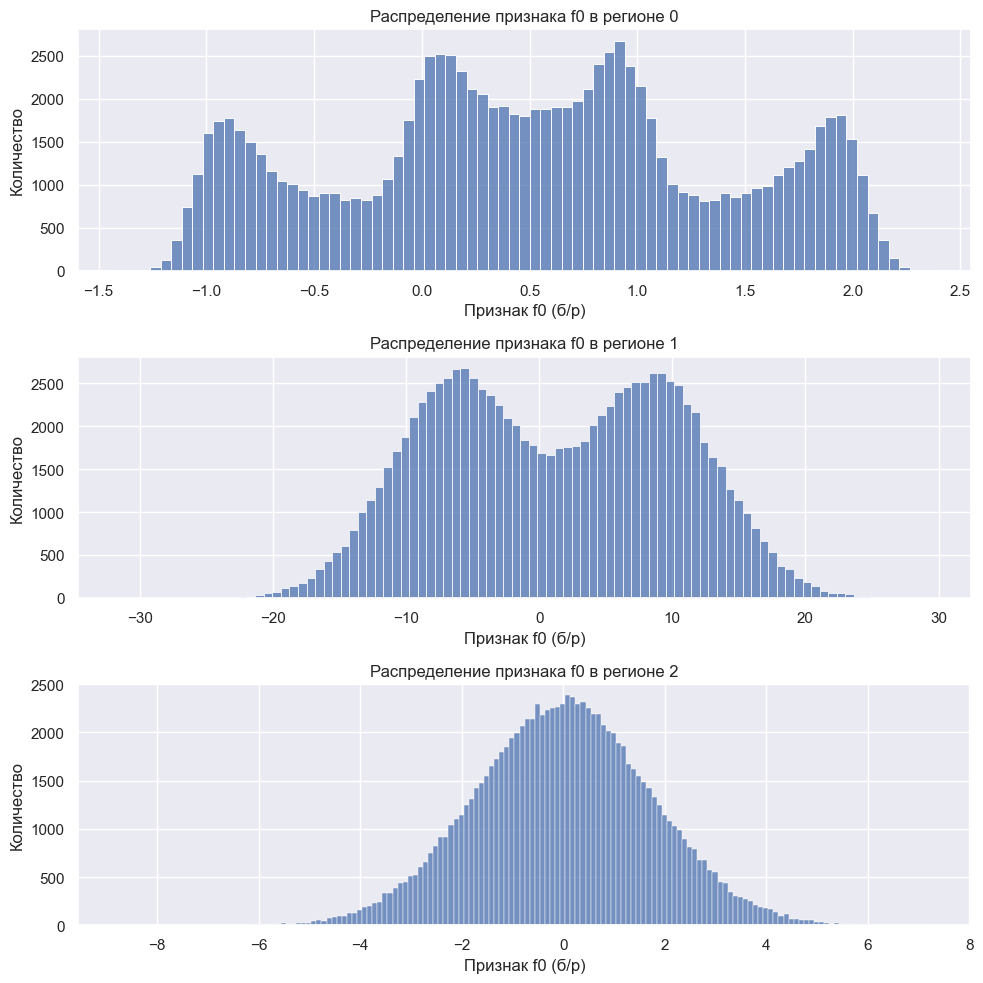

In [20]:
sns.set(rc = {'figure.figsize':(10, 10)})
for i, region in enumerate([0, 1, 2]):
    data_plot = plt.subplot(3, 1, i + 1)
    data_plot = sns.histplot(data[data.region==region]['f0'])
    data_plot.set_title('Распределение признака f0 в регионе %d' % region, size=12)
    data_plot.set_xlabel('Признак f0 (б/р)')
    data_plot.set_ylabel('Количество')
plt.tight_layout()
plt.show()

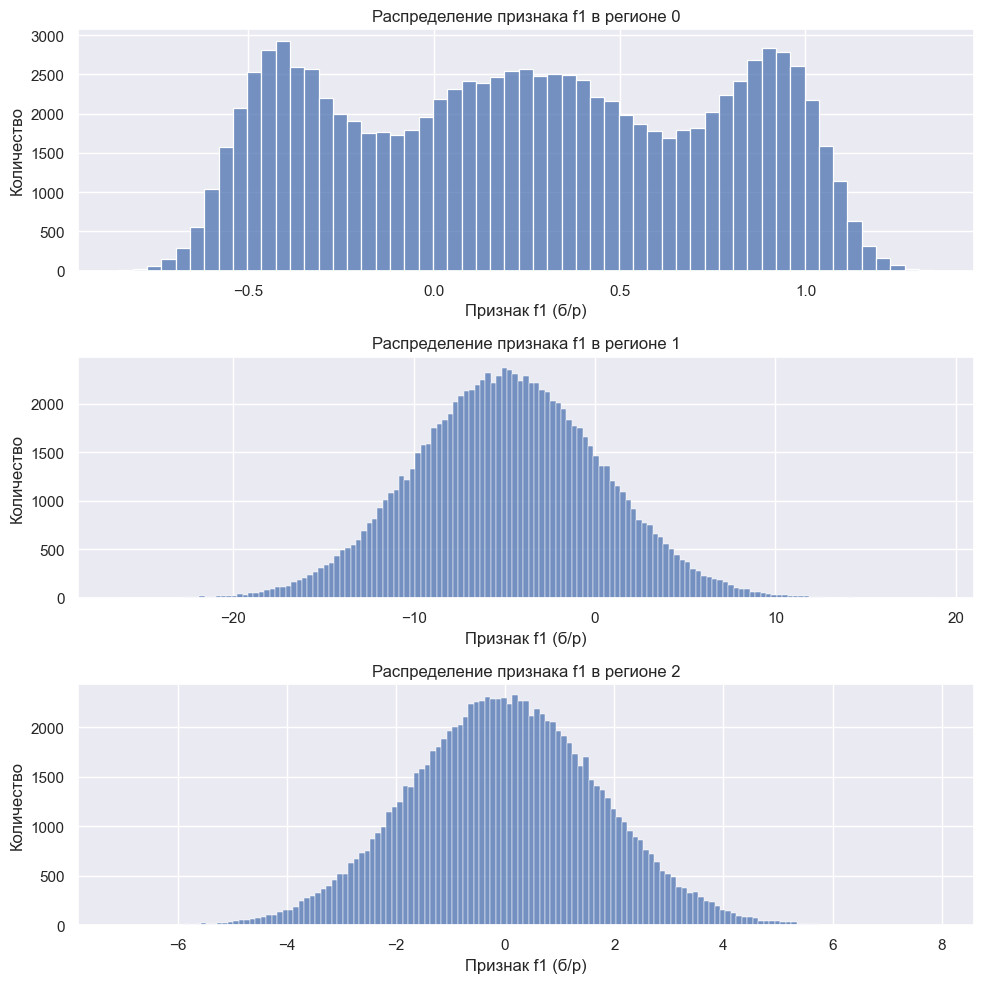

In [21]:
sns.set(rc = {'figure.figsize':(10, 10)})
for i, region in enumerate([0, 1, 2]):
    data_plot = plt.subplot(3, 1, i + 1)
    data_plot = sns.histplot(data[data.region==region]['f1'])
    data_plot.set_title('Распределение признака f1 в регионе %d' % region, size=12)
    data_plot.set_xlabel('Признак f1 (б/р)')
    data_plot.set_ylabel('Количество')
plt.tight_layout()
plt.show()

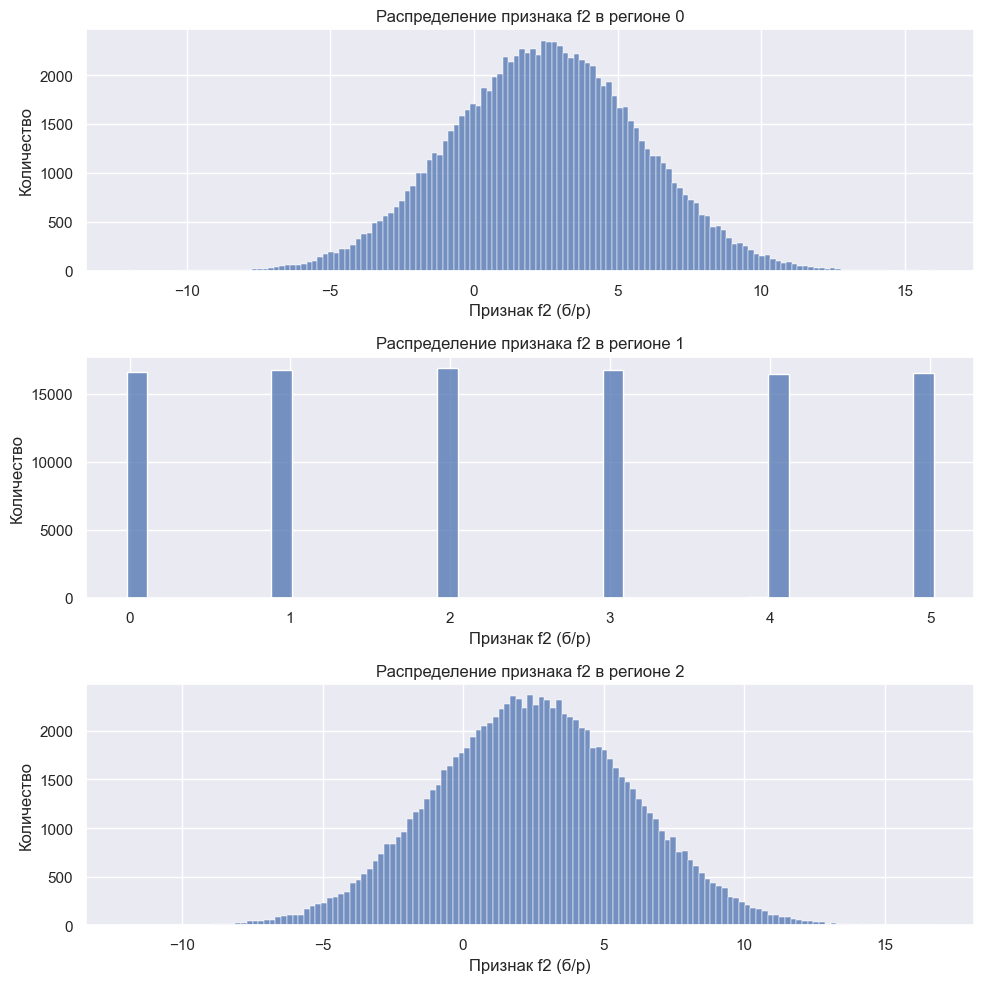

In [22]:
sns.set(rc = {'figure.figsize':(10, 10)})
for i, region in enumerate([0, 1, 2]):
    data_plot = plt.subplot(3, 1, i + 1)
    data_plot = sns.histplot(data[data.region==region]['f2'])
    data_plot.set_title('Распределение признака f2 в регионе %d' % region, size=12)
    data_plot.set_xlabel('Признак f2 (б/р)')
    data_plot.set_ylabel('Количество')
plt.tight_layout()
plt.show()

Признак f2 в 1-м регионе - числа, близкие к целым (с точностью до сотых), в одинаковых количествах. Что еще раз говорит о "синтетичности" данных по первому региону:

In [23]:
data[data.region==1].f2.value_counts().head()

-0.005876    1
 4.007133    1
 3.002704    1
 1.995378    1
 1.004327    1
Name: f2, dtype: int64

**Вывод**  

По всем трем регионам есть повторяющиеся id скважин: они могут совпадать в одном и том же регионе и иметь разные признаки, либо совпадать в разных регионах и также иметь разные признаки. Вероятнее всего дублирование id скважин произошло из-за ошибки генерации данных. Аналогично из-за некорректной генерации данных для скважины с id=uMqiK объем запасов в скважине = 0 тыс. барр (помимо дублей всего 8237 нулей по всему датасету). Для анализа и дальнейшей работы с датасетом было принято решение не избавляться от дубликатов/выбросов, т.к. в случае реальной задачи мы бы не могли влиять на распределение без дополнительно запрошенной информации о причине выбросов/дублирующихся скважин.  
  
Распределение запасов нефти в 0 и 2-м регионах практически идентичны. 1-ый регион имеет странное, не характерное распределение, что также может быть связано с искуственностью данных.    
  
Распределение признака f0 в нулевом регионе имеет несколько пиков - может влиять на модель. Также странное распределение имеет признак f2 в первом регионе - числа, близкие к целым, в одинаковых количествах.

## Обучение и проверка модели для каждого региона

### Разбиение данных на обучающую и валидационную выборки по регионам

Определим целевую переменную и признаки для тренировочного набора. Целевая переменная в данном случае - объём запасов в скважине (тыс. баррелей)`product`. Признаки - все остальные колонки, по которым мы будем предугадывать объем сырья. 

Разбиваем данные по 0-му региону на выборки:

In [24]:
features_0 = data[data.region==0].drop(['product','region'], axis=1)
target_0 = data[data.region==0]['product']

features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, target_0, test_size=0.25, random_state=42)

features_0_train.shape[0], features_0_valid.shape[0], target_0_train.shape[0], target_0_valid.shape[0]

(75000, 25000, 75000, 25000)

Разбиваем данные по 1-му региону на выборки:

In [25]:
features_1 = data[data.region==1].drop(['product','region'], axis=1)
target_1 = data[data.region==1]['product']

features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=42)

features_1_train.shape[0], features_1_valid.shape[0], target_1_train.shape[0], target_1_valid.shape[0]

(75000, 25000, 75000, 25000)

Разбиваем данные по 2-му региону на выборки:

In [26]:
features_2 = data[data.region==2].drop(['product','region'], axis=1)
target_2 = data[data.region==2]['product']

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size=0.25, random_state=42)

features_2_train.shape[0], features_2_valid.shape[0], target_2_train.shape[0], target_2_valid.shape[0]

(75000, 25000, 75000, 25000)

### Обучение модели LinearRegression, предсказания на валидационной выборке

Т.к. у нас все столбцы числовые и не требуют дополнительной предобработки (стандартизировать данные не будем, разброс данных относительно небольшой), попробуем сразу обучить модель линейной регрессии. А также сохраним предсказания на валидационной выборке в отдельных переменных в `predictions_list` (ответы у нас уже сохранены в переменных `target_i_valid`, где i - номер региона)

In [27]:
features_train = [features_0_train, features_1_train, features_2_train]
features_valid = [features_0_valid, features_1_valid, features_2_valid]
target_train = [target_0_train, target_1_train, target_2_train]
target_valid = [target_0_valid, target_1_valid, target_2_valid]
predictions_list = []

for i in range(0,3):
    model = LinearRegression()
    model.fit(features_train[i], target_train[i])
    predictions_valid = model.predict(features_valid[i])
    
    predictions_list.append(pd.Series(predictions_valid, index = target_valid[i].index))
                       
    result = mean_squared_error(target_valid[i], predictions_valid)**0.5
    print(f'RMSE модели линейной регрессии на валидационной выборке {i}: '\
          f'{round(result, ndigits=4)} тыс. барр')
    print(f'Средний запас предсказанного сырья на валидационной выборке {i}: '\
          f'{round(predictions_valid.mean(), ndigits=4)} тыс.барр')
    print()

RMSE модели линейной регрессии на валидационной выборке 0: 37.7566 тыс. барр
Средний запас предсказанного сырья на валидационной выборке 0: 92.3988 тыс.барр

RMSE модели линейной регрессии на валидационной выборке 1: 0.8903 тыс. барр
Средний запас предсказанного сырья на валидационной выборке 1: 68.7129 тыс.барр

RMSE модели линейной регрессии на валидационной выборке 2: 40.1459 тыс. барр
Средний запас предсказанного сырья на валидационной выборке 2: 94.771 тыс.барр



### Анализ результатов

Корень из средней квадратичной ошибки примерно одинаков для 0-го и 2-го регионов (37.76 и 94.77 тыс. баррелей соответственно) при одном порядке запасов сырья (92.40 и 94.77 тыс. баррелей). Если посмотреть на минимум и максимум фактических (`target`) запасов по этим двум регионам, а также на средний реальный объем сырья, то можно сделать вывод, что в целом модель корректно предсказала запасы, но по отдельным скважинам ошибка может быть большая, до 20-21%, что может принести потери.  
  
По 1-му региону ситуация лучше: RMSE = 0.8903 тыс. бар, несмотря на большой разброс между фактическими запасами сырья. Лучше всего наша модель предсказывает объем сырья именно для 1-го региона, без дополнительных рисков.

In [28]:
for i in range(0, 3):
    print(f'Статистические данные по %d-му региону, тыс. барр.' % i)
    print(target_valid[i].describe()[['min', 'mean', 'max']])
    print()

Статистические данные по 0-му региону, тыс. барр.
min       0.021781
mean     92.325956
max     185.355615
Name: product, dtype: float64

Статистические данные по 1-му региону, тыс. барр.
min       0.000000
mean     68.725381
max     137.945408
Name: product, dtype: float64

Статистические данные по 2-му региону, тыс. барр.
min       0.019327
mean     95.150999
max     190.011722
Name: product, dtype: float64



Посмотрим, почему такая большая ошибка получается для 0-го и 2-го регионов. Построим диаграмму рассеяния признаков от `target` для 0-го и 2-го регионов:

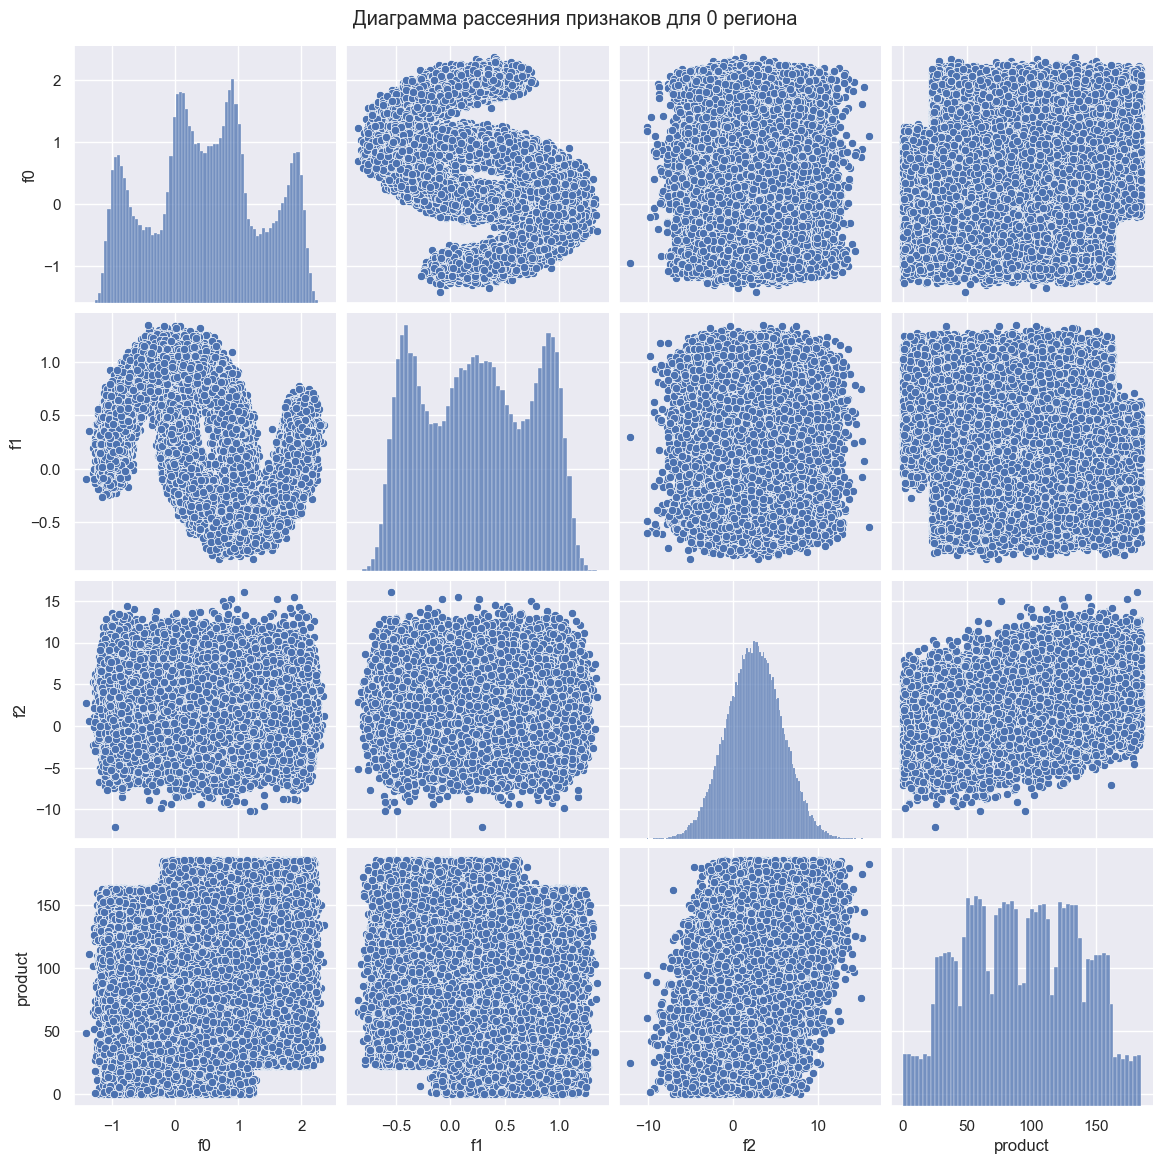

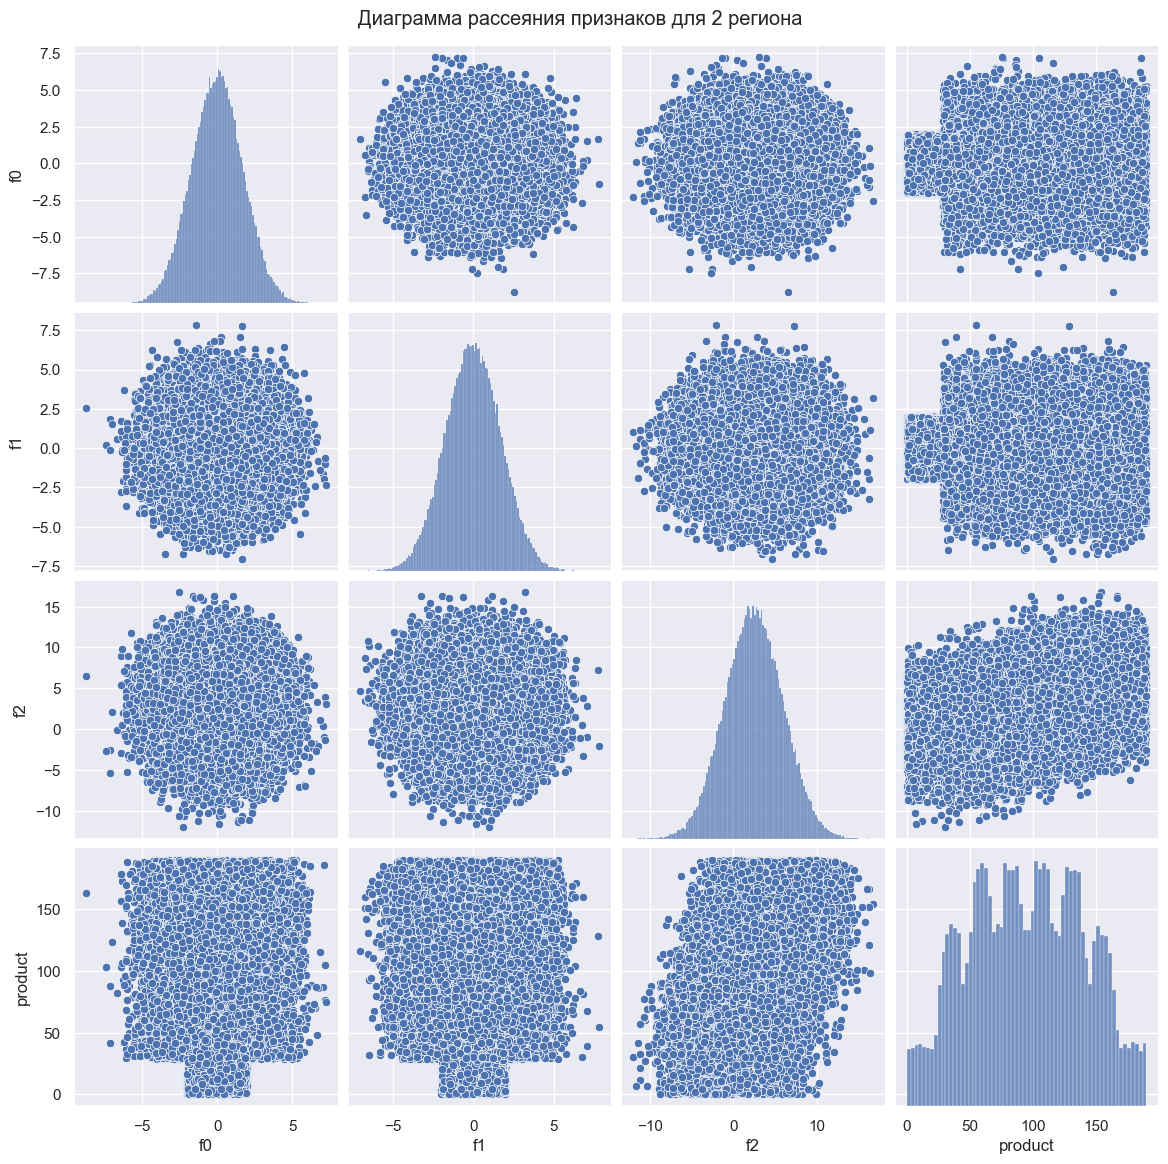

In [29]:
for region in range(0,3,2):
    data_scatt = sns.pairplot(data[data.region==region][['f0', 'f1', 'f2', 'product']])
    data_scatt.fig.subplots_adjust(top=.95)
    data_scatt.fig.suptitle('Диаграмма рассеяния признаков для %d региона' % region)
    plt.gcf().set_size_inches(12,12);

Предполагаю, что такая большая ошибка возникает из-за характера распределения признаков f0 и f1 по регионам в зависимости от объемов сырья. В 0-м регионе мы видим "обрезанные куски" признаков f0 и f1 вблизи минимума и максимума объема сырья. Во 2-м регионе мы видим "обрезанные куски" признаков f0 и f1 вблизи минимума сырья. То есть для обоих регионов, для скважин, где фактическая добыча очень мала, данные признаки могут быть учтены "по большинству" и модель предскажет большую добычу (ведь за исключением небольшого куска на малых объемах нефти, на остальных объемах данный признак распределен равномерно), что будет ошибочно и может привести к большим убыткам. Причем убытки на таких скважинах будут именно во втором регионе.  
Для первого региона на богатых запасами нефти скважинах наоборот признаки f0 и f1 могут привести модель к предсказанию меньшей добычи, чем заявлено. Для нулевого региона есть риск также упустить богатые скважины с большой прибылью.

## Расчет прибыли

Сохраним все ключевые значения для расчетов в отдельных переменных:

In [30]:
REGION_BUDGET = 10*(10**9) # бюджет на разработку 200 скважин в регионе, руб
WELL_BUDGET = REGION_BUDGET / 200 # бюджет на разработку одной скважины в регионе, руб
UNIT_INCOME = 450*(10**3) # доход с каждой единицы продукта (1 тыс. барр), руб
IVESTIGATED_QTY = 500
PROCESSED_QTY = 200

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [31]:
BREAKEVEN_OIL_VOL = WELL_BUDGET / UNIT_INCOME

print(f'Достаточный объем сырья для безубыточной разработки одной новой скважины: '\
      f'{round(BREAKEVEN_OIL_VOL, ndigits=2)} тыс.барр.')
print(f'Средний факт. запас сырья в 0-м регионе на 1 скважину: '\
      f'{round(target_0_valid.mean(), ndigits=2)} тыс. барр.')
print(f'Средний факт. запас сырья в 1-м регионе на 1 скважину: '\
      f'{round(target_1_valid.mean(), ndigits=2)} тыс. барр.')
print(f'Средний факт. запас сырья во 2-м регионе на 1 скважину: '\
      f'{round(target_2_valid.mean(), ndigits=2)} тыс. барр.')

Достаточный объем сырья для безубыточной разработки одной новой скважины: 111.11 тыс.барр.
Средний факт. запас сырья в 0-м регионе на 1 скважину: 92.33 тыс. барр.
Средний факт. запас сырья в 1-м регионе на 1 скважину: 68.73 тыс. барр.
Средний факт. запас сырья во 2-м регионе на 1 скважину: 95.15 тыс. барр.


В среднем фактические запасы сырья во всех трех регионах меньше, чем достаточный объем сырья для безубыточной разработки одной новой скважины. Поэтому мы не можем просто взять любые 200 скважин и разработать их - мы можем потерять деньги. Чтобы избежать убытков, необходимо обучить модель для расчёта прибыли по выбранным скважинам и предсказаниям модели.

## Расчёт прибыли по выбранным скважинам и предсказаниям модели

*Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:*  
*1) Выберите скважины с максимальными значениями предсказаний.*  
*2) Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.*   
*3) Рассчитайте прибыль для полученного объёма сырья.*  

Создадим датасеты с таргетом и предсказаниями для каждого региона для удобства:

In [32]:
data_0 = pd.DataFrame()
data_1 = pd.DataFrame()
data_2 = pd.DataFrame()
data = [data_0, data_1, data_2]

for i in range(0, 3):
    data[i]['target'] = target_valid[i]
    data[i]['predictions'] = predictions_list[i]

data_1.head()

target  predictions
175721    0.000000     0.844738
180184   53.906522    52.921612
119864  134.766305   135.110385
176699  107.813044   109.494863
192991    0.000000    -0.047292

Выберем 200 скважин с максимальными значениями предсказаний и посчитаем фактическую прибыль по регионам:

In [33]:
def region_profit(data, region):
    data = data.sort_values(by='predictions', ascending=False).head(PROCESSED_QTY)
    target_vol_sum = data.target.sum()
    profit = target_vol_sum * UNIT_INCOME - REGION_BUDGET
    return(target_vol_sum, profit)

In [34]:
region_list = [0, 1, 2]
data_list = [data_0, data_1, data_2]

for i in range(0, 3):
    vol, prof = region_profit(data_list[i], region_list[i])
    print(f'Фактический объём сырья в 200 скважинах %d-го региона: '\
          f'{round(vol, ndigits=4)} тыс. барр' % i)
    print(f'Прибыль от полученного объема сырья в регионе: '\
          f'{round(prof / (10**9), ndigits=4)} млрд. руб')
    print()

Фактический объём сырья в 200 скважинах 0-го региона: 29686.9803 тыс. барр
Прибыль от полученного объема сырья в регионе: 3.3591 млрд. руб

Фактический объём сырья в 200 скважинах 1-го региона: 27589.0815 тыс. барр
Прибыль от полученного объема сырья в регионе: 2.4151 млрд. руб

Фактический объём сырья в 200 скважинах 2-го региона: 27996.8261 тыс. барр
Прибыль от полученного объема сырья в регионе: 2.5986 млрд. руб



## Расчёт рисков и прибыли для каждого региона

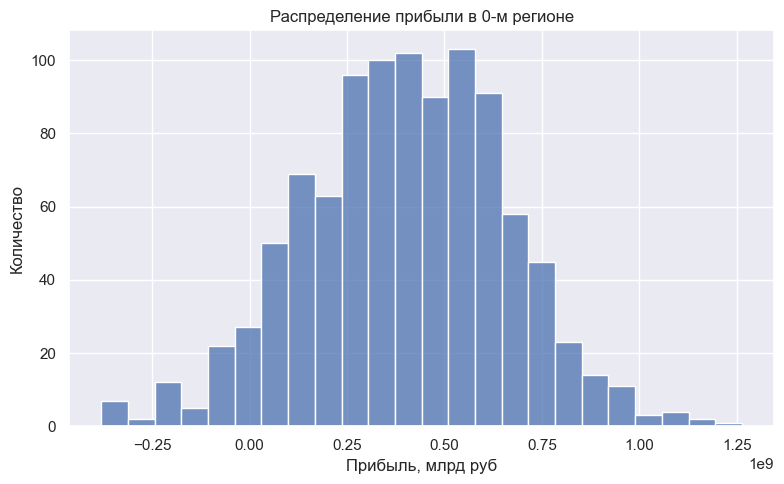

Средняя прибыль в 0-м регионе: 399.5755 млн.руб.
95%-й доверительный интервал в 0-м регионе: (-110.4679, 897.4603) млн.руб
Риск убытков в 0-м регионе: 6.0 %


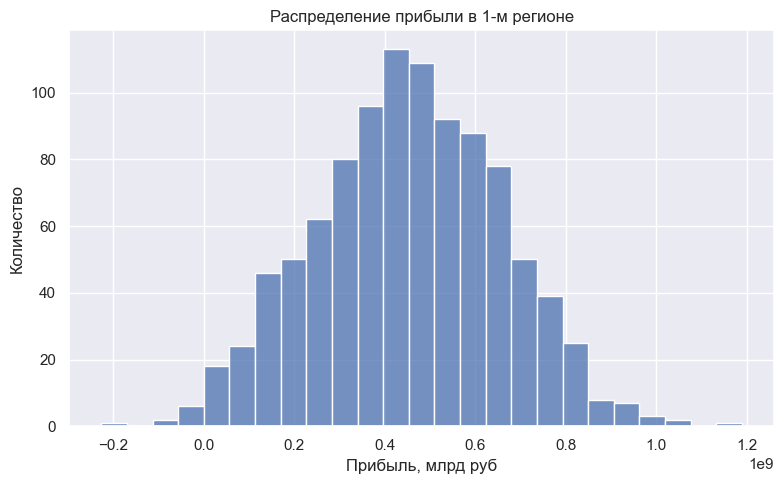

Средняя прибыль в 1-м регионе: 452.5766 млн.руб.
95%-й доверительный интервал в 1-м регионе: (52.3094, 830.1463) млн.руб
Риск убытков в 1-м регионе: 0.9 %


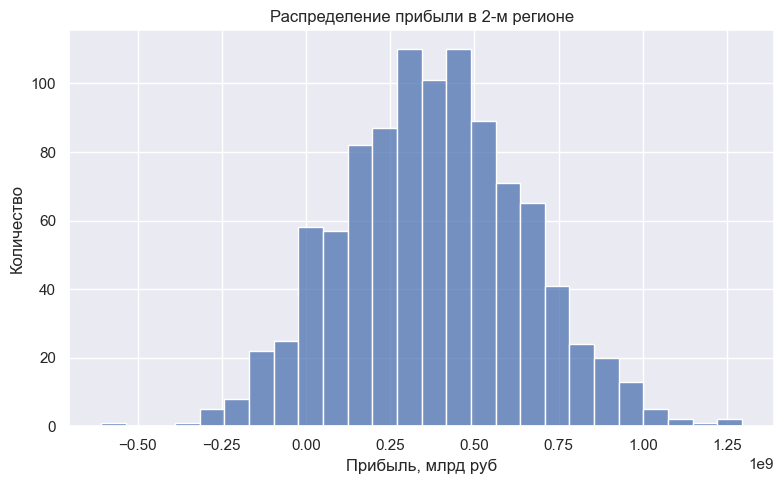

Средняя прибыль в 2-м регионе: 378.7059 млн.руб.
95%-й доверительный интервал в 2-м регионе: (-127.7794, 907.9235) млн.руб
Риск убытков в 2-м регионе: 7.5 %


In [35]:
state = np.random.RandomState(42)
values_0 = []
values_1 = []
values_2 = []
values = [values_0, values_1, values_2]

for j in range(0, 3):
    for i in range(1000):
        data_subsample = data_list[j].sample(n=IVESTIGATED_QTY, 
                                             replace=True,
                                             random_state=state)
        vol, prof = region_profit(data_subsample, region_list[j])
        values[j].append(prof)
    
    values[j] = pd.Series(values[j])

    sns.set(rc = {'figure.figsize':(8, 5)})
    data_plot = sns.histplot(values[j])
    data_plot.set_title('Распределение прибыли в %d-м регионе' %j, size=12)
    data_plot.set_xlabel('Прибыль, млрд руб')
    data_plot.set_ylabel('Количество')
    plt.tight_layout()
    plt.show()
    
    print(f'Средняя прибыль в %d-м регионе: '\
          f'{round(values[j].mean() / (10**6), ndigits=4)} млн.руб.' %j)
    
    lower = values[j].quantile(0.025)
    upper = values[j].quantile(0.975)
    
    print(f'95%%-й доверительный интервал в %d-м регионе: '\
          f'{round(lower/(10**6), ndigits=4), round(upper/(10**6), ndigits=4)} млн.руб' %j)
    
    # Риск - доля отрицательной прибыли от всей прибыли
    risk = round((values[j] < 0).mean() * 100, ndigits=2)
    print(f'Риск убытков в %d-м регионе: {risk} %%' %j)

## Вывод

По всем трем регионам есть повторяющиеся id скважин: они могут совпадать в одном и том же регионе и иметь разные признаки, либо совпадать в разных регионах и также иметь разные признаки. Вероятнее всего дублирование id скважин произошло из-за ошибки генерации данных. Аналогично из-за некорректной генерации данных для 8237 скважин выявлены нулевые значения `product` по всему датасету. Для анализа и дальнейшей работы с датасетом было принято решение не избавляться от дубликатов/выбросов, т.к. в случае реальной задачи мы бы не могли влиять на распределение без дополнительно запрошенной информации о причине выбросов/дублирующихся скважин. 
  
При расчете средних фактических запасов сырья было выявлено, что во всех трех регионах средние запасы сырья меньше чем достаточный объем сырья для безубыточной разработки одной новой скважины. Поэтому, чтобы избежать убытков, мы обучили модель для расчета прибыли по выбранным скважинам и предсказаниям модели.  
  
В результате проведенного анализа по трем регионам (0, 1 и 2) самым прибыльным регионом с наименьшими рисками является регион №1. В результате вычисления прибыли при помощи техники bootstrap мы получили следующие значения:  средняя прибыль в 1-м регионе составляет 452.58 млн руб , 95%-ый доверительный интервал лежит в диапазоне от 52.31 до 830.15 млн. руб - то есть убытки (отрицательные значения прибыли) лежат за пределом 95%-го доверительного интервала.  Риск убытков в 1-м регионе составляет 0.9%.  
  
Наименее прибыльный регион - №2. Он имеет наименьшую среднюю прибыль по региону = 378.71 млн. руб, а также самый высокий риск убытков: 7.5%. 
